In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from learningCurve import *
from features import *
from featureModels import featureModel
from learningCurve import plot_learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [104]:
masterDataset = pd.read_csv('../input/train.csv')
submissionDataset  = pd.read_csv('../input/test.csv')

def processDataset(dataset):
    produce_social_category(dataset)
    produce_age_category(dataset)
    produce_fare_category(dataset)
    produce_is_child(dataset)
    produce_family_size_and_is_alone(dataset)
    produce_gender(dataset)
    produce_embarked_location(dataset)
    fill_missing_age(dataset)
    reduce_fare_skew(dataset)
    # Drop useless 
    dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True) 
    
processDataset(masterDataset)

In [105]:
def fine_tune_model(model, modelParameters, dataset):
    Y_train = dataset["Survived"]
    X_train = dataset.drop(labels=["Survived"], axis=1)

    gridSearch = GridSearchCV(model, param_grid=modelParameters, cv=StratifiedKFold(n_splits=10), scoring="accuracy", n_jobs=4, verbose=1)
    gridSearch.fit(X_train, Y_train)

    return (gridSearch.best_estimator_, gridSearch.best_score_)

In [106]:
def fine_tune_random_forest(dataset):
    randomForest = RandomForestClassifier()
    randomForestParameters = {
        "max_depth": [None],
        "max_features": [1, 3, 10],
        "min_samples_split": [2, 3, 10, 20],
        "min_samples_leaf": [1, 3, 10, 20],
        "bootstrap": [False],
        "n_estimators": [100, 300],
        "criterion": ["gini"]
    }
    return fine_tune_model(randomForest, randomForestParameters, dataset)
  

In [109]:
def fine_tune_svc(dataset):
    svc = SVC(probability=True)
    svcParameters = {
        'kernel': ['rbf'],
        'gamma': [0.001, 0.01, 0.1, 1],
        'C': [1, 10, 50, 100, 200, 500, 1000]
    }

    return fine_tune_model(svc, svcParameters, dataset)

In [110]:
def fine_tune_gradient_boosting(dataset):
    gradientBoosting = GradientBoostingClassifier()
    gradientBoostingParameters = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
    }
    return fine_tune_model(gradientBoosting, gradientBoostingParameters, dataset)

In [111]:
def fine_tune_logistic_regression(dataset):
    logisticRegression = LogisticRegression()
    logisticRegressionParameters = {
        'C':  [1 , 0.75, 0.5, 0.25, 0.10, 0.001, 0.01, 0.0025, 0.005, 0.0075]
    }
    return fine_tune_model(logisticRegression, logisticRegressionParameters, dataset)
    

In [112]:
baseExcludes = ['Embarked', 'Cabin', 'Ticket', 'Sex', 'Name']

featureModels = [
    featureModel(masterDataset, submissionDataset, baseExcludes).getDatasets(),
    featureModel(masterDataset, submissionDataset, ['Embarked', 'Cabin', 'Ticket', 'Sex', 'Name']).getDatasets(),
    featureModel(masterDataset, submissionDataset, ['Embarked', 'Cabin', 'Ticket', 'Sex', 'Name', 'Parch', 'SibSp']).getDatasets(),
    featureModel(masterDataset, submissionDataset, ['Embarked', 'Cabin', 'Ticket', 'Sex', 'Name', 'Parch', 'SibSp', 'FareCategory']).getDatasets(),
]

In [118]:
def testModelsOnDataset(dataset):
    dataset["Survived"] = dataset["Survived"].astype(int)

    X_train = dataset.drop(labels=["Survived"], axis=1)
    Y_train = dataset["Survived"]

    crossValidationType = StratifiedKFold(n_splits=10)

    random_state = 0
    classifiers = [
        SVC(random_state=random_state),
        DecisionTreeClassifier(random_state=random_state),
        RandomForestClassifier(random_state=random_state),
        ExtraTreesClassifier(random_state=random_state),
        GradientBoostingClassifier(random_state=random_state),
        MLPClassifier(random_state=random_state),
        KNeighborsClassifier(),
        LogisticRegression(random_state=random_state),
        LinearDiscriminantAnalysis()
    ]

    cross_validation_results = []
    for classifier in classifiers:
        cross_validation_results.append(
            cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv= crossValidationType, n_jobs=4)
        )

    cross_validation_means = []
    for _ in cross_validation_results:
        cross_validation_means.append(_.mean())

    cross_validation_report = pd.DataFrame({
        'Mean accuracy': cross_validation_means,
        'Algorithm': [
            "SVC",
            "DecisionTree",
            "RandomForest",
            "ExtraTrees",
            "GradientBoosting",
            "MLP",
            "KNeighboors",
            "LogisticRegression",
            "LDA"
        ]
    }).sort_values(['Mean accuracy'], ascending=1)
    

    plt.figure(figsize=(16,4)) 
    g = sns.barplot(data= cross_validation_report, x='Algorithm', y='Mean accuracy', capsize=12)
    g.set_xlabel("CV Mean Accuracy")
    g.set_title("Cross validation scores")
    plt.show()

/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


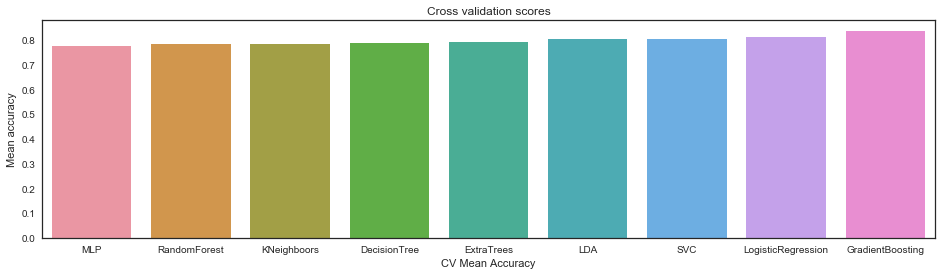

In [119]:
testModelsOnDataset(featureModels[0]['train'])

In [116]:
fineTunedModels = [
    fine_tune_random_forest(featureModels[0]['train']),
    fine_tune_svc(featureModels[0]['train']),
    fine_tune_gradient_boosting(featureModels[0]['train']),
    fine_tune_logistic_regression(featureModels[0]['train']),
    LinearDiscriminantAnalysis()
]

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.1s


[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   27.1s


[Parallel(n_jobs=4)]: Done 783 tasks      | elapsed:  1.1min


[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  1.3min finished


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s


[Parallel(n_jobs=4)]: Done 273 out of 280 | elapsed:   13.7s remaining:    0.4s


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   14.0s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    3.3s


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   15.0s finished


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


<module 'matplotlib.pyplot' from '/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/matplotlib/pyplot.py'>

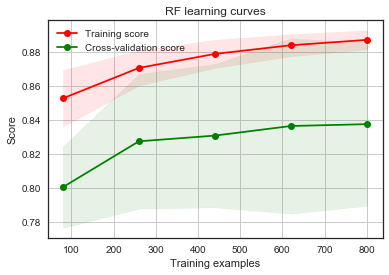

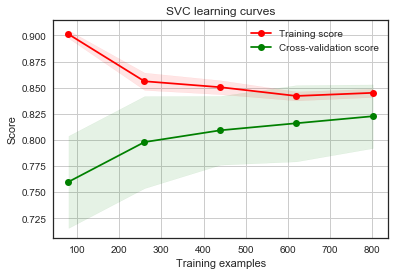

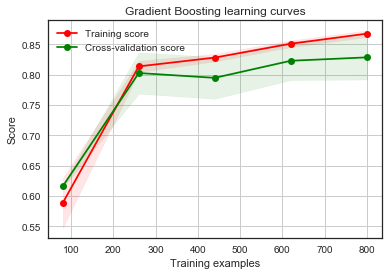

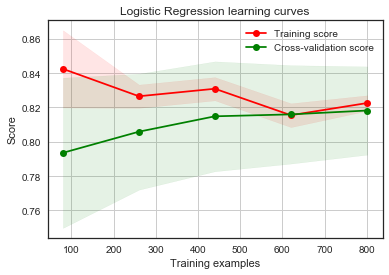

In [117]:

X_train = featureModels[0]['train'].drop(labels=["Survived"], axis=1)
Y_train = featureModels[0]['train']["Survived"]

plot_learning_curve(fineTunedModels[0][0],"RF learning curves",X_train,Y_train,cv=StratifiedKFold(n_splits=10))
plot_learning_curve(fineTunedModels[1][0],"SVC learning curves",X_train,Y_train,cv=StratifiedKFold(n_splits=10))
plot_learning_curve(fineTunedModels[2][0],"Gradient Boosting learning curves", X_train,Y_train,cv=StratifiedKFold(n_splits=10))
plot_learning_curve(fineTunedModels[3][0],"Logistic Regression learning curves",X_train,Y_train,cv=StratifiedKFold(n_splits=10))

In [98]:
bestEstimators = [
    ('RandomForest', fineTunedModels[0][0]),
    ('SVC', fineTunedModels[1][0]),
    ('GradientBoosting', fineTunedModels[2][0]),
    ('LogisticRegression', fineTunedModels[3][0])
]

votingEnsemble = VotingClassifier(estimators = bestEstimators, voting='soft', n_jobs=4)
crossValidationType = StratifiedKFold(n_splits=10)

X_train = featureModels[0]['train'].drop(labels=["Survived"], axis=1)
Y_train = featureModels[0]['train']["Survived"]

crossValidationScores = cross_val_score(votingEnsemble, X_train, Y_train, scoring='accuracy', cv= crossValidationType, n_jobs=4)
(crossValidationScores, crossValidationScores.mean())

/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


/Users/gboduljak/DevelopmentTools/Anaconda/anaconda/envs/machine-learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


(array([ 0.8       ,  0.85555556,  0.78651685,  0.88764045,  0.86516854,
         0.80898876,  0.83146067,  0.78651685,  0.86516854,  0.84090909]),
 0.83279253206219495)